Use Kaggle sample:
https://www.kaggle.com/kakauandme/tensorflow-deep-nn

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Deal with Data

In [2]:
# Import Libraries

import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf   # pip install tensorflow  

# settings
LEARNING_RATE = 1e-4

# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 10000        
    
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 2000

# image number to output
IMAGE_TO_DISPLAY = 10

/Users/lin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# Import data

#path="/Users/chloe/Desktop/ST445_Project"
path='/Users/lin/Desktop/ST443_Project_Data/Data' # another laptop
os.chdir(path)
data = pd.read_csv('mnist_train.csv', sep=',') 
#test = pd.read_csv('test.csv', sep=',')

## Knowing Data

In [4]:
print('data({0[0]},{0[1]})'.format(data.shape)) # (59999, 785) -> include one label

data(59999,785)


In [5]:
images = data.iloc[:,1:].values # all row, and from second col to last -> skip label in zero column
print(images.dtype)
images = images.astype(np.float)
print(images.shape)

int64
(59999, 784)


In [6]:
image_size = images.shape[1] #784 variables
print(image_size)

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

784
image_width => 28
image_height => 28


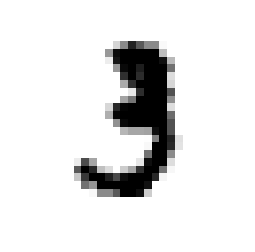

In [7]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off') #remove axis
    plt.imshow(one_image, cmap=cm.binary) #cmap=cm.binary -> display black/white image

# output image     
display(images[IMAGE_TO_DISPLAY])
display(images[9])

In [8]:
labels_flat = data.iloc[:,0].values.ravel() # make it array
print('labels_flat({0})'.format(len(labels_flat)))

labels_count = np.unique(labels_flat).shape[0] # have 10 numbers in the label: 0-9
print('labels_count => {0}'.format(labels_count)) 

labels_flat(59999)
labels_count => 10


## Convert labels from scalars to one-hot vectors

* A one-hot vector is a vector that contains a single element equal to 1 and the rest of the elements equal to 0. <br\> 
Ex: 0 => [1 0 0 0 0 0 0 0 0 0] <br\>
    1 => [0 1 0 0 0 0 0 0 0 0] <br\>
    ...                        <br\>
    9 => [0 0 0 0 0 0 0 0 0 1]

In [9]:
# convert class labels from scalars to one-hot vectors
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes # arange -> create array
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(59999,10)
labels[10] => [0 0 0 0 0 1 0 0 0 0]


In [10]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE] # we select 0:2000 as test; we set validation size=2000 (VALIDATION_SIZE = 2000)
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:] # we select 2000-42000 as train
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(57999,784)
validation_images(2000,784)


# Construct Neural Nework Structure
---
Neural Network Process: <br/>
image -> convolution -> max pooling -> convolution -> max pooling -> fully connected -> fully connected -> classifier

---
Ref:
* https://brohrer.mcknote.com/zh-Hant/how_machine_learning_works/how_convolutional_neural_networks_work.html
* http://cs231n.github.io/
* https://www.youtube.com/watch?v=tjcgL5RIdTM&list=PLXO45tsB95cKI5AIlf5TxxFPzb-0zeVZ8&index=26

* Things should notice for Weight initialization:

Note that we do not know what the final value of every weight should be in the trained network, but with proper data normalization it is reasonable to assume that approximately half of the weights will be positive and half of them will be negative. 
A reasonable-sounding idea then might be to set all the initial weights to zero, which we expect to be the “best guess” in expectation. This turns out to be a mistake, because if every neuron in the network computes the same output, then they will also all compute the same gradients during backpropagation and undergo the exact same parameter updates. In other words, there is no source of asymmetry between neurons if their weights are initialized to be the same.
Therefore, **we still want the weights to be very close to zero, but as we have argued above, not identically zero. As a solution, it is common to initialize the weights of the neurons to small numbers and refer to doing so as symmetry breaking.**

* what is weight: http://cs231n.github.io/neural-networks-1/#nn
* concept of weight and bias: y=ax+b (a: weight; b: bias)

In [11]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1) # create normal distribution
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [12]:
# convolution: https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-04-CNN2/
def conv2d(x, W):
    # x: all inputs; W: weight
    # strides[1,x_movement,y_movement,1]: the output is the same size as the input
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') 

In [13]:
# pooling : extract the maximum value
# [[0,3],[4,2]] => 4

def max_pool_2x2(x):
    # strides=[1,2,2,1] -> make 2(1+1_xmovement)*2(1+1_ymovement) into 1*1 -> squize the image 
    # ksize: extract info from 2*2 
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [14]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size]) #image_siae=784 (28*28)
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

# change the shape of x (784 -> 28*28)
image = tf.reshape(x, [-1,image_width , image_height,1]) # -1: n_sample 1: our display image is in black/white 

In [15]:
# conv1 layer
W_conv1 = weight_variable([5, 5, 1, 32]) # patch:5*5; in size:1; out size:32
b_conv1 = bias_variable([32])
image = tf.reshape(x, [-1,image_width , image_height,1]) # =>(59999,28,28,1)
h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1) # hidden layer convl; tf.nn.relu: make it non-linear 
# outpt size of h_convl will be 28*28*32
h_pool1 = max_pool_2x2(h_conv1)
# output size of h_pool will be 14*14*32


# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 


# conv2 layer
W_conv2 = weight_variable([5, 5, 32, 64]) #patch:5*5; in size(width):32; out size(height):64
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # hidden layer convl; tf.nn.relu: make it non-linear 
# outpt size of h_convl will be 14*14*64
h_pool2 = max_pool_2x2(h_conv2)
# output size of h_pool will be 7*7*64


# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 



# func1 layer: hidden layer
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64]) # [n_sample, 7,7,64] -> [n_sample, 7*7*64]
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob) # dropout: avoid overfit, apply this b4 readout layer


# func2 layer: hidden layer (output layer輸出層)
W_fc2 = weight_variable([1024, labels_count]) #labels_count: contains 0-9
b_fc2 = bias_variable([labels_count])
y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2) # use softmax to calculate probability

## Evaluate Performance

In [16]:
# cost function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

#cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [17]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [18]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [19]:
# start TensorFlow session
init = tf.global_variables_initializer()
#init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

In [20]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})


training_accuracy / validation_accuracy => 0.04 / 0.10 for step 0
training_accuracy / validation_accuracy => 0.16 / 0.08 for step 1
training_accuracy / validation_accuracy => 0.10 / 0.08 for step 2
training_accuracy / validation_accuracy => 0.08 / 0.08 for step 3
training_accuracy / validation_accuracy => 0.04 / 0.08 for step 4
training_accuracy / validation_accuracy => 0.10 / 0.08 for step 5
training_accuracy / validation_accuracy => 0.10 / 0.08 for step 6
training_accuracy / validation_accuracy => 0.08 / 0.08 for step 7
training_accuracy / validation_accuracy => 0.12 / 0.08 for step 8
training_accuracy / validation_accuracy => 0.08 / 0.08 for step 9
training_accuracy / validation_accuracy => 0.12 / 0.08 for step 10
training_accuracy / validation_accuracy => 0.16 / 0.08 for step 20
training_accuracy / validation_accuracy => 0.10 / 0.08 for step 30
training_accuracy / validation_accuracy => 0.14 / 0.08 for step 40
training_accuracy / validation_accuracy => 0.10 / 0.08 for step 50
train

KeyboardInterrupt: 

In [ ]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()